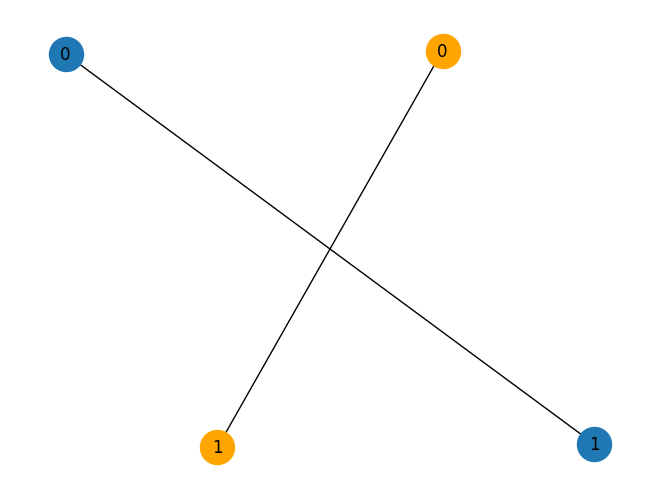

In [2]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

# m = 5
# g = rx.PyGraph()
# g.add_nodes_from(np.arange(0, m, 1))
# e_g_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
# g.add_edges_from(e_g_list)
# draw_graph(g, node_size=600, with_labels=True, node_color='orange')

# n = 3
# h = rx.PyGraph()
# h.add_nodes_from(np.arange(0, n, 1))
# e_h_list = [(0, 1, 1.0), (0, 2, 1.0)]
# h.add_edges_from(e_h_list)
# draw_graph(h, node_size=600, with_labels=True)

m = 2
g = rx.PyGraph()
g.add_nodes_from(np.arange(0, m, 1))
e_g_list = [(0, 1, 1.0)]
g.add_edges_from(e_g_list)
draw_graph(g, node_size=600, with_labels=True, node_color='orange')

n = 2
h = rx.PyGraph()
h.add_nodes_from(np.arange(0, n, 1))
e_h_list = [(0, 1, 1.0)]
h.add_edges_from(e_h_list)
draw_graph(h, node_size=600, with_labels=True)

In [3]:
e_g = np.zeros((m,m))
for edge in e_g_list:
    e_g[edge[0], edge[1]] = edge[2]
    e_g[edge[1], edge[0]] = edge[2]

e_h = np.zeros((n,n))
for edge in e_h_list:
    e_h[edge[0], edge[1]] = edge[2]
    e_h[edge[1], edge[0]] = edge[2]

print(e_g)
print(e_h)

[[0. 1.]
 [1. 0.]]
[[0. 1.]
 [1. 0.]]


In [4]:
# Constructing Q
Q = np.zeros((m*n, m*n))
for i in range(m):
    for j in range(m):
        for u in range(n):
            for v in range(n):
                Q[i*n+u, j*n+v] = e_g[i, j] * e_h[u, v]

# Adding penalty for attempting to map input to multiple outputs
# See if this can be balanced for weighted graphs

# Add blocks like 0 & -m & -m \\ -m & 0 & -m \\ -m & -m & 0 (if size of H = 3)
for i in range(m):
    start = i*n
    end = (i+1)*n
    for j in range(start, end):
        for k in range(start, end):
            if j != k:
                Q[j, k] -= m # penalty of m outweighs the highest possible reward for assigning an input to two outputs
print(Q)

[[ 0. -2.  0.  1.]
 [-2.  0.  1.  0.]
 [ 0.  1.  0. -2.]
 [ 1.  0. -2.  0.]]


In [5]:
from qiskit.quantum_info import SparsePauliOp

# see https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm
# H_c = sum Q_{ij}Z_iZ_j + sum b_iZ_i

pauli_list = []
for a in range(len(Q)):
    c = 0
    for b in range(len(Q[a])):
        if Q[a, b] != 0:
            paulis = ["I"] * len(Q)
            paulis[a], paulis[b] = "Z", "Z"
            weight = Q[a, b] # should always be 1 for now
            weight *= -1 # -weight to convert from minimizing problem to maximizing
            pauli_list.append(("".join(paulis), weight))

            c -= Q[a, b] + Q[b, a]
    paulis = ["I"] * len(Q)
    paulis[a] = "Z"
    pauli_list.append(("".join(paulis), -c)) # -c to convert from minimizing problem to maximizing
    
print(pauli_list)
cost_hamiltonian = SparsePauliOp.from_list(pauli_list)
print("Cost Function Hamiltonian:", cost_hamiltonian)

[('ZZII', 2.0), ('ZIIZ', -1.0), ('ZIII', -2.0), ('ZZII', 2.0), ('IZZI', -1.0), ('IZII', -2.0), ('IZZI', -1.0), ('IIZZ', 2.0), ('IIZI', -2.0), ('ZIIZ', -1.0), ('IIZZ', 2.0), ('IIIZ', -2.0)]
Cost Function Hamiltonian: SparsePauliOp(['ZZII', 'ZIIZ', 'ZIII', 'ZZII', 'IZZI', 'IZII', 'IZZI', 'IIZZ', 'IIZI', 'ZIIZ', 'IIZZ', 'IIIZ'],
              coeffs=[ 2.+0.j, -1.+0.j, -2.+0.j,  2.+0.j, -1.+0.j, -2.+0.j, -1.+0.j,  2.+0.j,
 -2.+0.j, -1.+0.j,  2.+0.j, -2.+0.j])


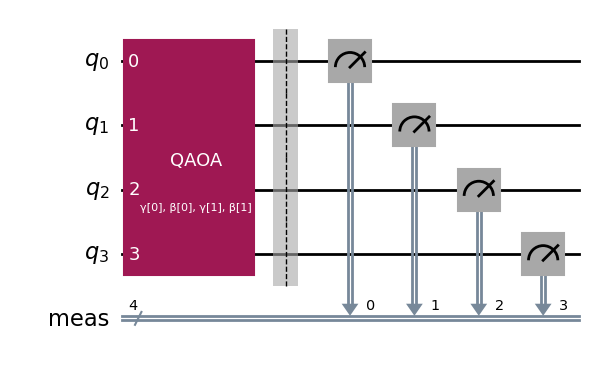

In [6]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [7]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

In [8]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# # QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
# service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.least_busy(min_num_qubits=127)
# print(backend)

# # Create pass manager for transpilation
# pm = generate_preset_pass_manager(optimization_level=3,
#                                     backend=backend)

# candidate_circuit = pm.run(circuit)
# candidate_circuit.draw('mpl', fold=False, idle_wires=False)

AerSimulator('aer_simulator')


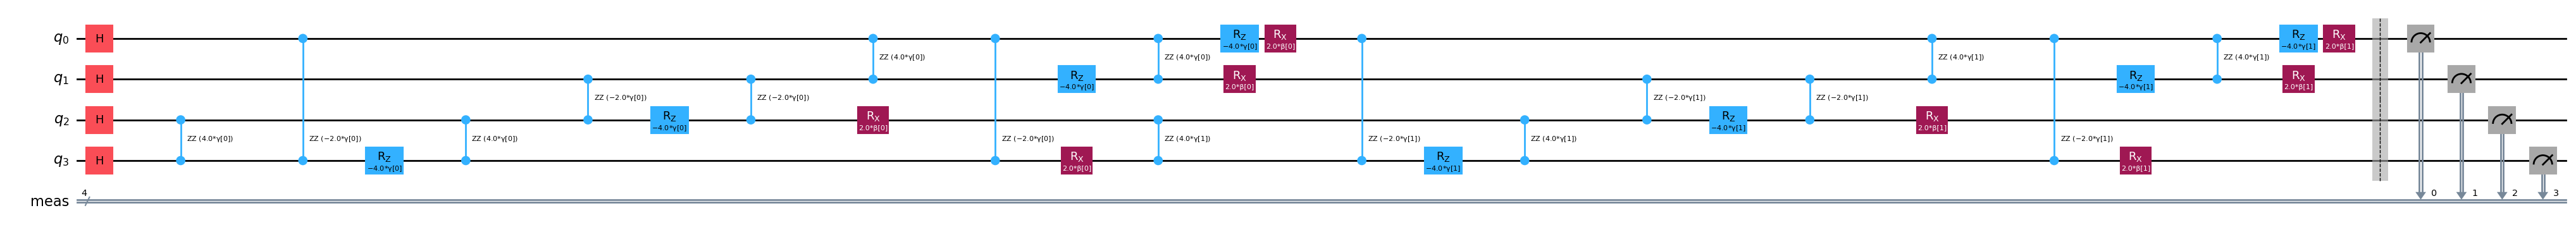

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

backend = AerSimulator()
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [10]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [11]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [22]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

/home/cab3/code/cmsc320/.venv/lib/python3.8/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/cab3/code/cmsc320/.venv/lib/python3.8/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/cab3/code/cmsc320/.venv/lib/python3.8/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates'

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.412587412587413
       x: [ 4.166e+00  1.687e+00  3.243e+00  1.511e+00]
    nfev: 32
   maxcv: 0.0


/home/cab3/code/cmsc320/.venv/lib/python3.8/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/cab3/code/cmsc320/.venv/lib/python3.8/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/cab3/code/cmsc320/.venv/lib/python3.8/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates'

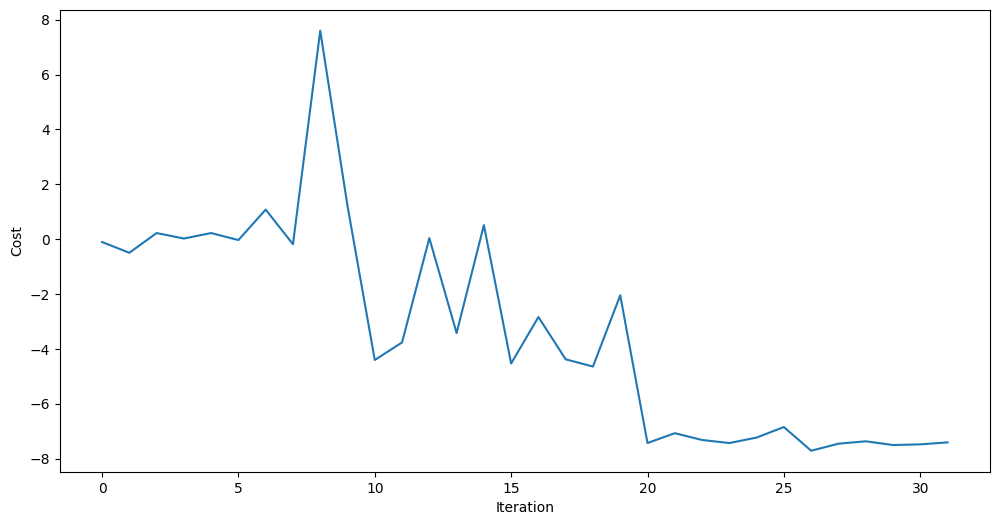

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

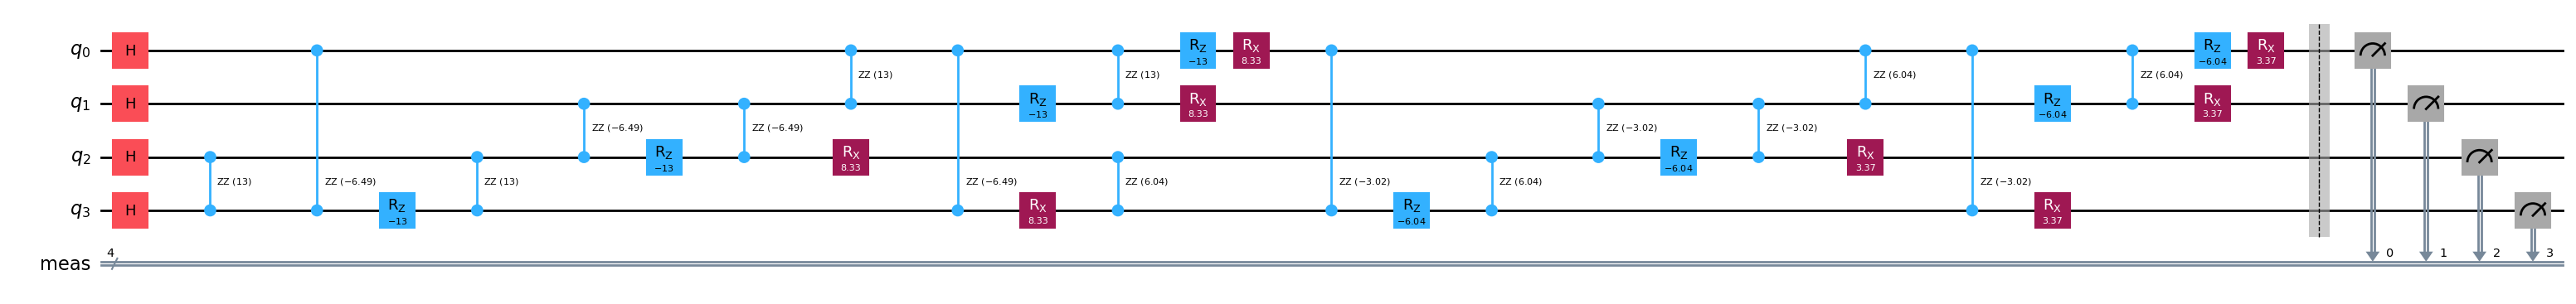

In [24]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [25]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e6))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

/home/cab3/code/cmsc320/.venv/lib/python3.8/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


{10: 0.11385, 9: 0.247452, 6: 0.247531, 5: 0.113828, 8: 0.048977, 2: 0.048613, 15: 0.010411, 4: 0.049372, 1: 0.048869, 0: 0.055692, 12: 0.006564, 3: 0.006628, 7: 0.000557, 14: 0.000579, 11: 0.000539, 13: 0.000538}


In [26]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(Q))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 0]


In [17]:
# takes ages to run this with 1,000,000 inputs

# import matplotlib.pyplot as plt
# import matplotlib

# matplotlib.rcParams.update({"font.size": 10})
# final_bits = final_distribution_bin
# values = np.abs(list(final_bits.values()))
# fig = plt.figure(figsize=(11, 6))
# ax = fig.add_subplot(1, 1, 1)
# plt.xticks(rotation=45)
# plt.title("Result Distribution")
# plt.xlabel("Bitstrings (reversed)")
# plt.ylabel("Probability")
# ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
# plt.show()

In [27]:
most_likely_bitstring

hom = np.zeros((m, n))
for i in range(m):
    for j in range(n):
        hom[i, j] = most_likely_bitstring[i*n + j]
hom

array([[0., 1.],
       [1., 0.]])